## Learn to classify

Sample using scikit-learn "Machine Learning in Python" to create efficient MAV code.

In this example a simple color classifier is learned from sample data.

Add some images and labels to the data folder. 
 - Image file names should end with c.jpg 
 - Masks/labels should be black and white images with a filename ending with m.jpg

In [3]:
# Load the images

import cv2
import numpy as np
import glob

from random import randrange

images = glob.glob( './data/*c.jpg', recursive=True)
labels = glob.glob( './data/*m.jpg', recursive=True)

print(images)

['./data\\i0001c.jpg']


From all the images and all the masks, create one large vector containing all training samples. 
 - The input vector has three columns for Y U V
 - The output has the label, ground or non-ground
 
 _Tip: modify the code to add several adjacent pixels as inputs_

In [4]:
# Convert images to training data (vector)

X_vec = []
y_vec = []

maxfiles = 500
samples_per_image = 75000

for f in images:
    lf = f.replace('c.jpg', 'm.jpg')
    if lf in labels:
        maxfiles = maxfiles - 1
        if maxfiles <=0:
            break

        img = cv2.imread(f)
        msk = cv2.imread(lf)
        h,w,d = img.shape

        print('img=',f,'lbl=',lf,w,'x',h)

        # Color space of RAW Bebop Images
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img[:,:,1] = msk[:,:,0]


        for i in range(0,samples_per_image):
            
            x = randrange(2,w-3)
            y = randrange(4,h-2)

            # Pixels
            p = yuv[y,x]
            # Ground thruth
            m = int(msk[y,x,0])
            if m < 127:
                m = 0
            else:
                m=255

            # Y, U, V
            X_vec.append([int(p[0]),int(p[1]),int(p[2])])
            y_vec.append([m])
        

print('Dataset',len(X_vec), len(y_vec))

img= ./data\i0001c.jpg lbl= ./data\i0001m.jpg 520 x 240
Dataset 75000 75000


Use 20% of the data as test data and 80% as training data

In [6]:
# Split training data and test data

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, test_size=0.2, stratify=y_vec, random_state=1)

print('Train',len(X_train), len(y_train))
print('Test',len(X_test), len(y_test))



Train 60000 60000
Test 15000 15000


Create a DecisionTreeClassifier, train and show the score.

In [12]:
# Train

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(max_depth=2, random_state=0)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Sensitivity:',round(score,3))


Sensitivity: 0.992


### Export

The decision tree can be exported. Convert this to c-code to run it on the drone.

In [15]:
# Export

from sklearn.tree import export_text

text_representation = export_text(dt, feature_names=['Y','U','V'])

print(text_representation)


|--- U <= 115.50
|   |--- V <= 145.00
|   |   |--- class: 255
|   |--- V >  145.00
|   |   |--- class: 0
|--- U >  115.50
|   |--- U <= 118.50
|   |   |--- class: 0
|   |--- U >  118.50
|   |   |--- class: 0



### Result

Show the resulting classfication by overwriting the V color channel.

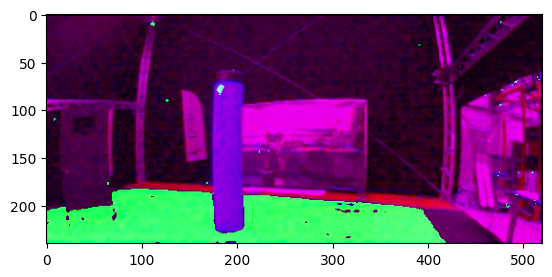

In [16]:
from matplotlib import pyplot as plt

for f in images:
    img = cv2.imread(f)
    h,w,d = img.shape

    # Load an image
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    X_run = yuv.reshape(int(h*w),int(d))
    y_pred = dt.predict(X_run)
    msk = y_pred.reshape(h,w)
    
    img[:,:,1] = msk[:,:]

    plt.imshow(img)

# Next steps

 - Improve the classifier by for instance changing the ```max_depth```
 - Plot the quality of each classifier you make as a point in the ROC-curve (TP/FP)
 - What happens with the _sensitivity_ when you add more images with changes in appearance (e.g. from the simulator)
 - Augment your dataset to make the classification still work with more/less light (e.g. from the _dataset.zip_)
 - Try to find other types of obstacles or more classes of obstacles.